<a href="https://colab.research.google.com/github/alik604/The-Best-Ensemble/blob/master/examples/The_Best_Ensemble_Cover_Type_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://github.com/alik604/The-Best-Ensemble/blob/master/examples/dataset%20-%20cover%20type/covtype.data.gz?raw=true -O data.gz
!gunzip -k data.gz
!head data

--2020-06-28 20:04:20--  https://github.com/alik604/The-Best-Ensemble/blob/master/examples/dataset%20-%20cover%20type/covtype.data.gz?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/alik604/The-Best-Ensemble/raw/master/examples/dataset%20-%20cover%20type/covtype.data.gz [following]
--2020-06-28 20:04:21--  https://github.com/alik604/The-Best-Ensemble/raw/master/examples/dataset%20-%20cover%20type/covtype.data.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alik604/The-Best-Ensemble/master/examples/dataset%20-%20cover%20type/covtype.data.gz [following]
--2020-06-28 20:04:21--  https://raw.githubusercontent.com/alik604/The-Best-Ensemble/master/examples/dataset%20-%20cover%20type/covtype.data.gz
Resolving raw.githubusercontent.com (raw.g



```
Attribute Information:

Given is the attribute name, attribute type, the measurement unit and a brief description. The forest cover type is the classification problem. The order of this listing corresponds to the order of numerals along the rows of the database.

Name / Data Type / Measurement / Description

Elevation / quantitative /meters / Elevation in meters
Aspect / quantitative / azimuth / Aspect in degrees azimuth
Slope / quantitative / degrees / Slope in degrees
Horizontal_Distance_To_Hydrology / quantitative / meters / Horz Dist to nearest surface water features
Vertical_Distance_To_Hydrology / quantitative / meters / Vert Dist to nearest surface water features
Horizontal_Distance_To_Roadways / quantitative / meters / Horz Dist to nearest roadway
Hillshade_9am / quantitative / 0 to 255 index / Hillshade index at 9am, summer solstice
Hillshade_Noon / quantitative / 0 to 255 index / Hillshade index at noon, summer soltice
Hillshade_3pm / quantitative / 0 to 255 index / Hillshade index at 3pm, summer solstice
Horizontal_Distance_To_Fire_Points / quantitative / meters / Horz Dist to nearest wildfire ignition points
Wilderness_Area (4 binary columns) / qualitative / 0 (absence) or 1 (presence) / Wilderness area designation
Soil_Type (40 binary columns) / qualitative / 0 (absence) or 1 (presence) / Soil Type designation
Cover_Type (7 types) / integer / 1 to 7 / Forest Cover Type designation
```



In [2]:
%%capture
!pip install scikit-plot
!pip install catboost
!pip install mlxtend

import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import * 
from sklearn.preprocessing import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import *
from sklearn.kernel_approximation import Nystroem

from mlxtend.classifier import EnsembleVoteClassifier
import copy

import matplotlib.pyplot as plt
import scikitplot as skplt

import xgboost  # xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier
import lightgbm # lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
import catboost # catboost.ai/docs/concepts/python-quickstart.html

In [3]:
data = pd.read_csv('data',header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [4]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,0.448865,0.051434,0.436074,0.063627,0.005217,0.012952,0.008301,0.021335,0.002749,0.011316,0.000181,0.000308,0.001974,0.056168,0.021359,0.051584,0.030001,0.001031,0.000005,0.004897,0.005890,0.003268,0.006921,0.015936,0.001442,0.057439,0.099399,0.036622,0.000816,0.004456,0.001869,0.001628,0.198356,0.051927,0.044175,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,2.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,0.497379,0.220882,0.495897,0.244087,0.072039,0.113066,0.090731,0.144499,0.052356,0.105775,0.013442,0.017550,0.044387,0.230245,0.144579,0.221186,0.170590,0.032092,0.002272,0.069804,0.076518,0.057077,0.082902,0.125228,0.037950,0.232681,0.299197,0.187833,0.028551,0.066605,0.043193,0.040318,0.398762,0.221879,0.205483,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [5]:
y = data[54] # data.loc[:,54]
X = data.drop([54], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42) 

In [6]:
wanted_explained_variance_ratio = 0.99
steps_down = 2
wanted_n_components = X_train.shape[1]
first_time = True

for i in range(X_train.shape[1]-1, 1, -steps_down):
  total_var_ratio = round(np.sum(PCA(n_components=i).fit(X_train).explained_variance_ratio_), 5)
  print('i =', i, 'with a variance ratio of', total_var_ratio)
  if total_var_ratio < wanted_explained_variance_ratio and first_time:
    wanted_n_components = i + steps_down
    first_time = False

print("We should set n_components to: ",wanted_n_components)

i = 53 with a variance ratio of 1.0
i = 51 with a variance ratio of 1.0
i = 49 with a variance ratio of 1.0
i = 47 with a variance ratio of 1.0
i = 45 with a variance ratio of 1.0
i = 43 with a variance ratio of 1.0
i = 41 with a variance ratio of 1.0
i = 39 with a variance ratio of 1.0
i = 37 with a variance ratio of 1.0
i = 35 with a variance ratio of 1.0
i = 33 with a variance ratio of 1.0
i = 31 with a variance ratio of 1.0
i = 29 with a variance ratio of 1.0
i = 27 with a variance ratio of 1.0
i = 25 with a variance ratio of 1.0
i = 23 with a variance ratio of 1.0
i = 21 with a variance ratio of 1.0
i = 19 with a variance ratio of 1.0
i = 17 with a variance ratio of 1.0
i = 15 with a variance ratio of 1.0
i = 13 with a variance ratio of 1.0
i = 11 with a variance ratio of 1.0
i = 9 with a variance ratio of 1.0
i = 7 with a variance ratio of 0.99989
i = 5 with a variance ratio of 0.99917
i = 3 with a variance ratio of 0.98754
We should set n_components to:  5


In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# skip PCA on the frist round.. just for fun 
# pca = PCA(n_components=wanted_n_components) # want 26ish to 28ish components, if you want 99% of variance explained
# _ = pca.fit(X_train)
# X_train = pca.transform(X_train)
# X_test = pca.transform(X_test)

In [8]:
DTC = DecisionTreeClassifier(random_state=42) 
RFC = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
ETC = ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1)
XGB = xgboost.XGBClassifier(n_estimators=150, random_state=42, n_jobs=-1)
GBM = lightgbm.LGBMClassifier(n_estimators=400, random_state=42, n_jobs=-1, objective='multiclass')

list_of_CLFs_names = []
list_of_CLFs = [DTC, RFC, ETC, XGB, GBM]
ranking = []

for clf in list_of_CLFs: 
    _ = clf.fit(X_train,y_train)
    pred = clf.score(X_test,y_test)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Acc: %0.5f for the %s" % (pred, name))

    ranking.append(pred)
    list_of_CLFs_names.append(name)


Acc: 0.89210 for the DecisionTreeClassifier
Acc: 0.92368 for the RandomForestClassifier
Acc: 0.92613 for the ExtraTreesClassifier
Acc: 0.75628 for the XGBClassifier
Acc: 0.88610 for the LGBMClassifier


In [9]:
#CAUTION: Very Expensive
CBC = catboost.CatBoostClassifier(eval_metric='AUC', use_best_model=True, random_seed=42) # loss_function - https://catboost.ai/docs/concepts/python-reference_parameters-list.html#python-reference_parameters-list
CBC.fit(X_train,y_train,eval_set=(X_test, y_test))
pred = CBC.score(X_test,y_test)
name = str(type(CBC)).split(".")[-1][:-2]
print("Acc: %0.5f for the %s" % (pred, name))

ranking.append(pred)
list_of_CLFs.append(CBC)
list_of_CLFs_names.append(name)

Learning rate set to 0.119281
0:	test: 0.8396671	best: 0.8396671 (0)	total: 410ms	remaining: 6m 49s
1:	test: 0.8590557	best: 0.8590557 (1)	total: 762ms	remaining: 6m 20s
2:	test: 0.8725988	best: 0.8725988 (2)	total: 1.11s	remaining: 6m 8s
3:	test: 0.8866767	best: 0.8866767 (3)	total: 1.45s	remaining: 6m 1s
4:	test: 0.8984602	best: 0.8984602 (4)	total: 1.81s	remaining: 5m 59s
5:	test: 0.9052046	best: 0.9052046 (5)	total: 2.23s	remaining: 6m 8s
6:	test: 0.9075212	best: 0.9075212 (6)	total: 2.59s	remaining: 6m 7s
7:	test: 0.9112282	best: 0.9112282 (7)	total: 2.98s	remaining: 6m 9s
8:	test: 0.9134116	best: 0.9134116 (8)	total: 3.35s	remaining: 6m 9s
9:	test: 0.9169556	best: 0.9169556 (9)	total: 3.72s	remaining: 6m 8s
10:	test: 0.9224770	best: 0.9224770 (10)	total: 4.1s	remaining: 6m 8s
11:	test: 0.9261873	best: 0.9261873 (11)	total: 4.48s	remaining: 6m 9s
12:	test: 0.9309702	best: 0.9309702 (12)	total: 4.86s	remaining: 6m 9s
13:	test: 0.9326810	best: 0.9326810 (13)	total: 5.25s	remaining: 

In [10]:
best = max(ranking)
avg = sum(ranking)/len(ranking)
variance = avg - best
to_remove = ranking - avg - variance
to_remove_alt = ranking - best - variance

print(list_of_CLFs_names)
print(to_remove)
print(to_remove_alt)

['DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'XGBClassifier', 'LGBMClassifier', 'CatBoostClassifier']
[ 0.06390076  0.09548244  0.09793563 -0.07191972  0.05790204  0.05050575]
[ 0.01493295  0.04651463  0.04896782 -0.12088754  0.00893422  0.00153793]


In [11]:
ranking = np.array(ranking)[to_remove > 0]
list_of_CLFs = np.array(list_of_CLFs)[to_remove > 0]

In [12]:
eclf = EnsembleVoteClassifier(clfs=list_of_CLFs, refit=False, voting='soft')
eclf.fit(X_train, y_train)
pred = eclf.score(X_test, y_test)
print("Acc: %0.5f for the %s" % (pred, str(type(eclf)).split(".")[-1][:-2]))

Acc: 0.92504 for the EnsembleVoteClassifier


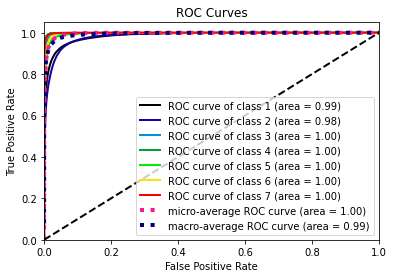

In [13]:
pred = eclf.predict(X_test)
probas = eclf.predict_proba(X_test)
skplt.metrics.plot_roc(y_true=y_test, y_probas=probas)
plt.show()

In [14]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

## TODO type check
if type(y_test) is (pd.core.frame.DataFrame or pd.core.series.Series):
  y_test = y_test.values

def benchmark(y_test=y_test, pred=pred, pred_proba=None):
    from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, accuracy_score, auc, roc_curve, roc_auc_score, hamming_loss, precision_score, recall_score, f1_score, log_loss

    print("Hamming_loss: \t\t", round(hamming_loss(y_test, pred), 3))                       # HL=1-Accuracy
    print("Precision_score: \t", round(precision_score(y_test, pred, average='micro'), 3))  # tp / (tp + fp)
    print("Recall_score: \t\t", round(recall_score(y_test, pred, average='micro'), 3))      # tp / (tp + fn)
    print("F1 score: \t\t", round(f1_score(y_test, pred, average='micro'), 3))              # 2 * (precision * recall) / (precision + recall)
    print("------------------------------")
    print("Accuracy_score: \t", round(accuracy_score(y_test, pred), 3))
    
    fpr, tpr, _ = roc_curve(y_test == 6, pred == 6)                                         # 6 is "Normal", rest are 'bad'
    print("False Positive Rate - binarized ", fpr)
    print("True Positive Rate  - binarized ", tpr)
    # roc_auc_score(y_test.values, pred, average="micro", multi_class = "ovo")
    print("Area of ROC: \t", round(auc(fpr, tpr), 3))                                       # Apx definite integral... of the ROC
    print("------------------------------")
    if pred_proba is not None: 
      # FYI, `is not` is an operator in it's own right. Like !=.
      print("Log loss (categorical cross entropy): \t", round(log_loss(y_test, pred_proba), 3))   # -log P(yt|yp) = -(yt log(yp) + (1 - yt) log(1 - yp))

benchmark(y_test, pred, probas)

sklearn.metrics.multilabel_confusion_matrix(y_test,pred)

Hamming_loss: 		 0.075
Precision_score: 	 0.925
Recall_score: 		 0.925
F1 score: 		 0.925
------------------------------
Accuracy_score: 	 0.925
False Positive Rate - binarized  [0.         0.00329302 1.        ]
True Positive Rate  - binarized  [0.         0.84617153 1.        ]
Area of ROC: 	 0.921
------------------------------
Log loss (categorical cross entropy): 	 0.243


array([[[266880,  10271],
        [ 14563, 144045]],

       [[206013,  17235],
        [ 10591, 201920]],

       [[406485,   2352],
        [  1659,  25263]],

       [[433474,    238],
        [   370,   1677]],

       [[428017,    532],
        [  2287,   4923]],

       [[421320,   1392],
        [  2007,  11040]],

       [[419699,    646],
        [  1189,  14225]]])